In [ ]:
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, boxcox
from scipy import stats
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split



numpy version :  1.22.4
pandas version :  1.5.3
seaborn version :  0.12.2


# **TUGAS 1**

# Introduction
Notebook ini berisi **Tugas 1** yang saya kerjakan, dimana menampilkan  EDA (exploratory data analysis), pemodelan regresi, prediksi, serta evaluasi dari data [House Prices](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

**Objective**

Terdapat 1460 data pada data train. Total jumlah atribut sama dengan 81, dimana 36 adalah kuantitatif/numerik, 43 kualitatif/kategori + **Id** dan **SalePrice**. Dimana **SalePrice** akan digunakan sebagai target variabel yang **diprediksi** dalam pemodelan yang akan dilakukan.

**Instruction**<br>
* Exploratory Data Analysis
* Modeling
* Evaluasi
* Insight

## Load Data

In [ ]:
from google.colab import files
uploade = files.upload()

Saving train.csv to train.csv


In [ ]:
df = pd.read_csv('train.csv',sep=',')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## **Exploratory Data Analysis**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
df.shape

(1460, 81)

### Check Null and Missing Values

In [ ]:
data_missing_value = df.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(df))*100,2)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage
0,PoolQC,1453,99.52
1,MiscFeature,1406,96.30
2,Alley,1369,93.77
3,Fence,1179,80.75
4,FireplaceQu,690,47.26
5,LotFrontage,259,17.74
6,GarageYrBlt,81,5.55
7,GarageCond,81,5.55
8,GarageType,81,5.55
9,GarageFinish,81,5.55


Terdapat 19 atribut yang memiliki *missing values*, 4 diantaranya bahkan lebih dari 50%. Dan hampir semua merupakan data kualitatif. Hanya ada 3 variabel numerik/kuantitatif.

In [ ]:
col_missing_value = data_missing_value['feature'].tolist()
df[col_missing_value].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PoolQC        7 non-null      object 
 1   MiscFeature   54 non-null     object 
 2   Alley         91 non-null     object 
 3   Fence         281 non-null    object 
 4   FireplaceQu   770 non-null    object 
 5   LotFrontage   1201 non-null   float64
 6   GarageYrBlt   1379 non-null   float64
 7   GarageCond    1379 non-null   object 
 8   GarageType    1379 non-null   object 
 9   GarageFinish  1379 non-null   object 
 10  GarageQual    1379 non-null   object 
 11  BsmtFinType2  1422 non-null   object 
 12  BsmtExposure  1422 non-null   object 
 13  BsmtQual      1423 non-null   object 
 14  BsmtCond      1423 non-null   object 
 15  BsmtFinType1  1423 non-null   object 
 16  MasVnrArea    1452 non-null   float64
 17  MasVnrType    1452 non-null   object 
 18  Electrical    1459 non-null 

[Text(0, 0, 'PoolQC'),
 Text(1, 0, 'MiscFeature'),
 Text(2, 0, 'Alley'),
 Text(3, 0, 'Fence'),
 Text(4, 0, 'FireplaceQu'),
 Text(5, 0, 'LotFrontage'),
 Text(6, 0, 'GarageYrBlt'),
 Text(7, 0, 'GarageCond'),
 Text(8, 0, 'GarageType'),
 Text(9, 0, 'GarageFinish'),
 Text(10, 0, 'GarageQual'),
 Text(11, 0, 'BsmtFinType2'),
 Text(12, 0, 'BsmtExposure'),
 Text(13, 0, 'BsmtQual'),
 Text(14, 0, 'BsmtCond'),
 Text(15, 0, 'BsmtFinType1'),
 Text(16, 0, 'MasVnrArea'),
 Text(17, 0, 'MasVnrType'),
 Text(18, 0, 'Electrical')]

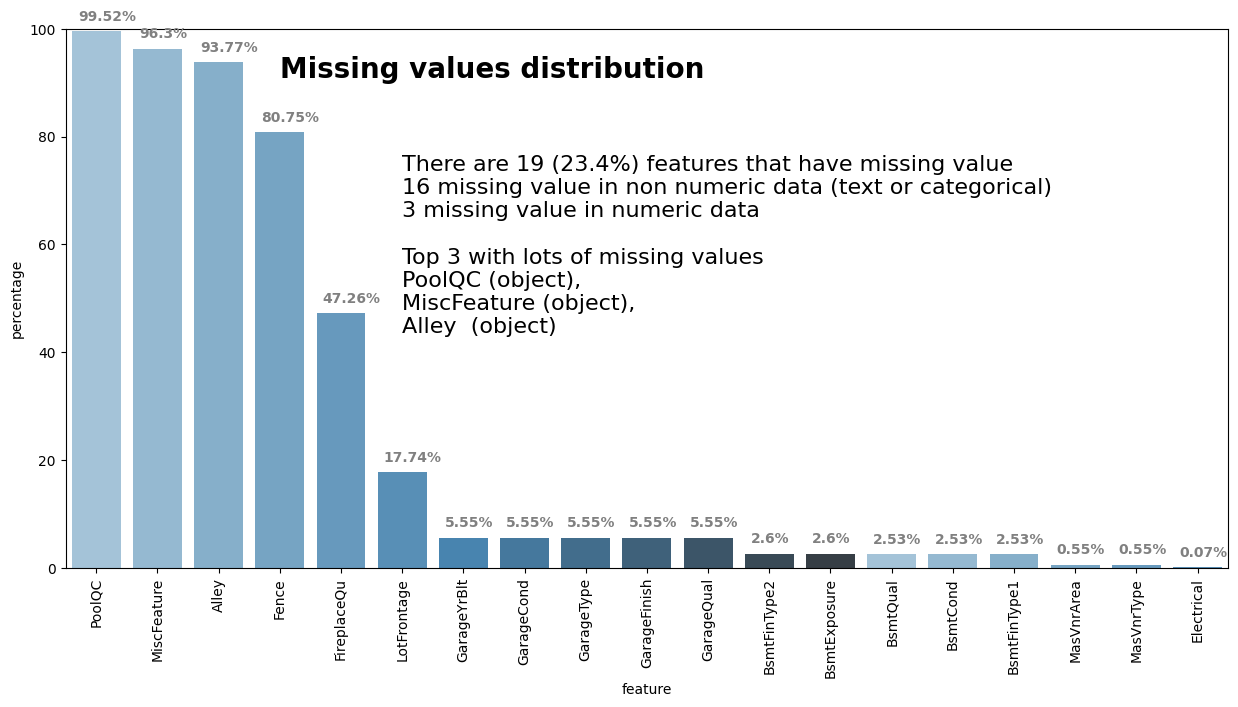

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

g = sns.barplot(x = 'feature',y='percentage',data=data_missing_value,ax=ax,
               palette=sns.color_palette("Blues_d", n_colors=13, desat=1))

x = np.arange(len(data_missing_value['feature']))
y = data_missing_value['percentage']

for i, v in enumerate(y):
    ax.text(x[i]-0.3, v+2, str(v)+'%', fontsize = 10, color='gray', fontweight='bold')

title = '''
Missing values distribution
'''
ax.text(3,85,title,horizontalalignment='left',color='black',fontsize=20,fontweight='bold')


text = '''
There are 19 (23.4%) features that have missing value
16 missing value in non numeric data (text or categorical)
3 missing value in numeric data

Top 3 with lots of missing values
PoolQC (object),
MiscFeature (object),
Alley  (object)

'''
ax.text(5,35,text,horizontalalignment='left',color='black',fontsize=16,fontweight='normal')

ax.set_ylim(0,100)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

###  Handle Missing Values - Numerical
Berdasarkan hasil sebelumnya terdapat 3 variabel numeric yang memiliki missing values dengan rincian berikut.

*   LotFrontage - 259	(17.74%)
*   GarageYrBlt - 81	(5.55%)
*   MasVnrArea - 8	(0.55%)

In [ ]:
nums=df[['LotFrontage','GarageYrBlt','MasVnrArea']]

In [ ]:
nums.describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
GarageYrBlt,1379.0,1978.506164,24.689725,1900.0,1961.0,1980.0,2002.0,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.0,0.0,166.0,1600.0


<Axes: xlabel='LotFrontage', ylabel='Density'>

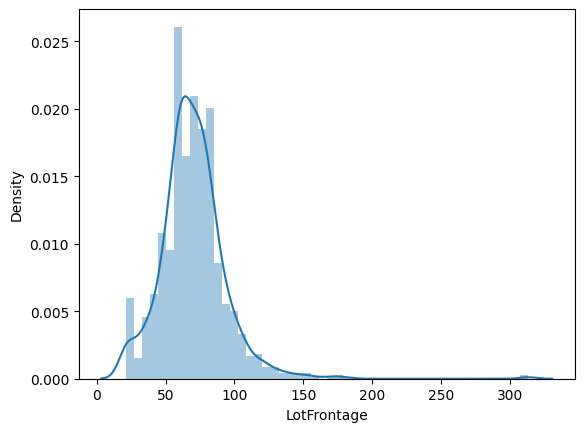

In [ ]:
sns.distplot(df['LotFrontage'])

<Axes: xlabel='GarageYrBlt', ylabel='Density'>

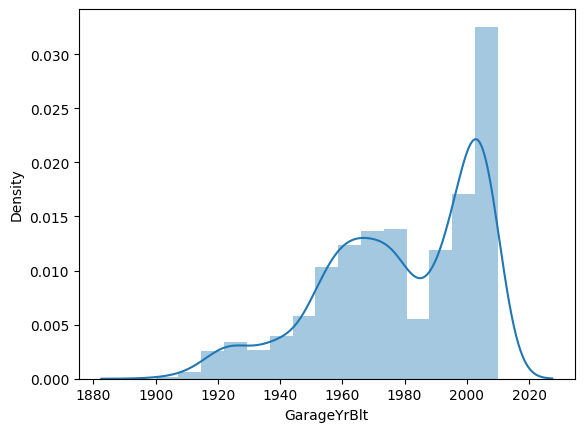

In [ ]:
sns.distplot(df['GarageYrBlt'])

<Axes: xlabel='MasVnrArea', ylabel='Density'>

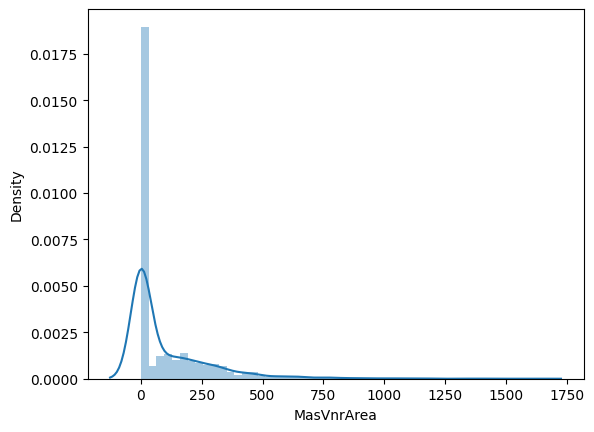

In [ ]:
sns.distplot(df['MasVnrArea'])

Karena ketiga atribut tidak normal, maka missing values pada ketiganya akan diisi dengan nilai mediannya.

In [ ]:
#Mengisi nilai yang hilang dengan median
df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].median())
df['GarageYrBlt']=df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())
df['MasVnrArea']=df['MasVnrArea'].fillna(df['MasVnrArea'].median())

### Transform categorical variables

#### Check Cardinality

In [ ]:
display(df.select_dtypes(include=['object']).columns)
print(df.select_dtypes(include=object).shape)
data_cat = df.select_dtypes(include=['object'])
data_cat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

(1460, 43)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [ ]:
data_missing_value = df.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(df))*100,2)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage
0,PoolQC,1453,99.52
1,MiscFeature,1406,96.30
2,Alley,1369,93.77
3,Fence,1179,80.75
4,FireplaceQu,690,47.26
5,GarageFinish,81,5.55
6,GarageType,81,5.55
7,GarageQual,81,5.55
8,GarageCond,81,5.55
9,BsmtExposure,38,2.60


Untuk beberapa kolom ada banyak data NaN.
Namun, membaca deskripsi data dapat diketahui bahwa ini bukan data yang hilang:
Untuk PoolQC, NaN bukan data yang hilang tetapi berarti no Pool, demikian juga untuk Fence, FireplaceQu dll.

In [ ]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df[col].fillna('None',inplace=True)

In [ ]:
data_missing_value = df.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(df))*100,2)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage


Sudah tidak ada missing values pada keseluruhan data

## Matrix Correlation

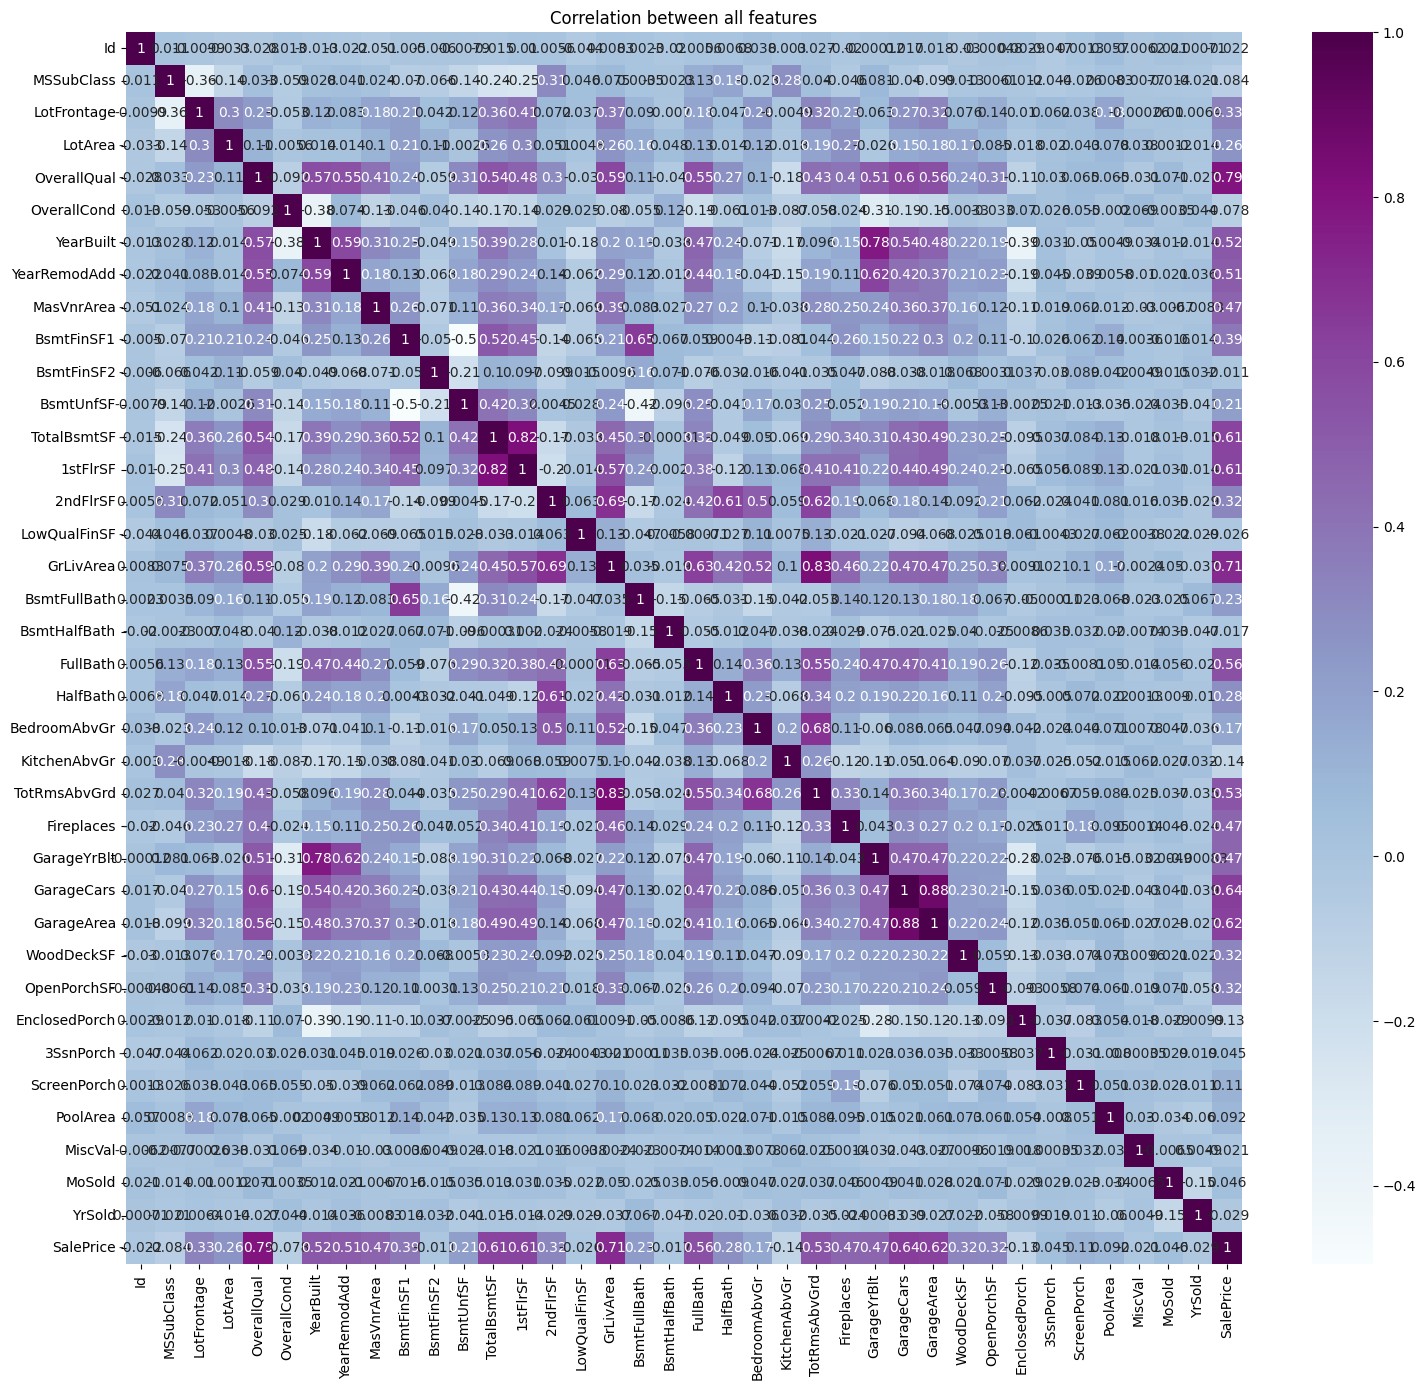

In [ ]:
df_corr = df.corr()

plt.figure(figsize = (18, 16))
sns.heatmap(df_corr, annot=True, cmap='BuPu')
plt.title('Correlation between all features')
plt.show()

In [ ]:
df_corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
GarageYrBlt      0.466754
BsmtFinSF1       0.386420
LotFrontage      0.334771
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

OverallQual memiliki korelasi tertinggi dengan SalePrice

### LotFrontage Feature

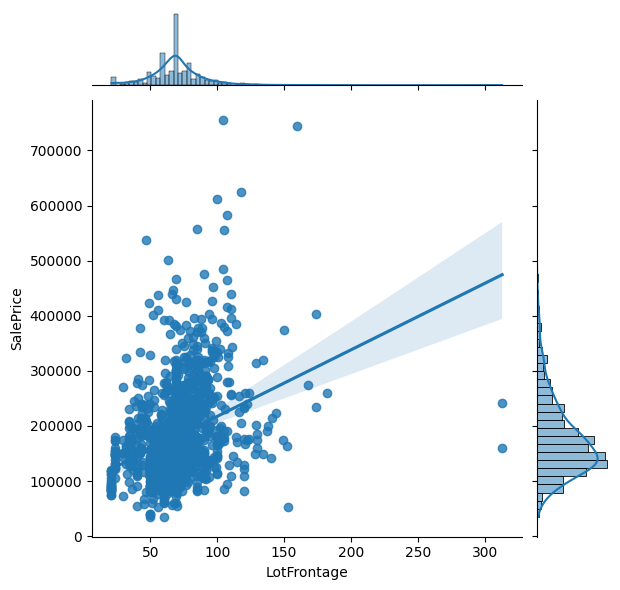

In [ ]:
sns.jointplot(x="LotFrontage", y="SalePrice", data=df, kind="reg");

106


[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.])]

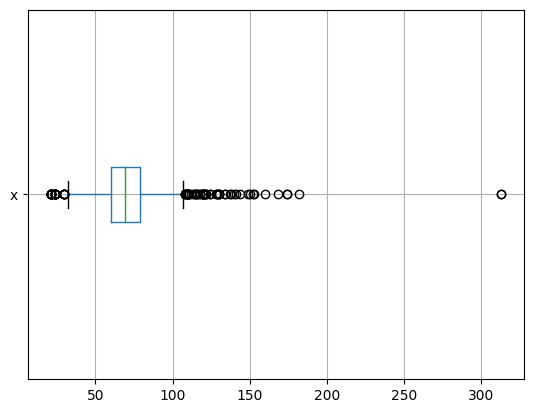

In [ ]:
_, bp = pd.DataFrame.boxplot((df['LotFrontage']), return_type='both',vert=False)

outliers = [flier.get_ydata() for flier in bp["fliers"]]
print(len(outliers[0]))
outliers[0].min()
outliers

Fitur `LotFrontage` memiliki korelasi positif terhadap SalePrice. Secara hipotesis, artinya jika ada kenaikan pada jarak jalan untuk pejalan kaki menuju properti terkait maka akan berdampak pada kenaikan harga dari properti tersebut. Selain itu terdapat 106 (7.2%) outlier pada `LotFrontage`, artinya ada yang memiliki `LotFrontage` yang tidak masuk akal.

### GarageYrBlt Feature

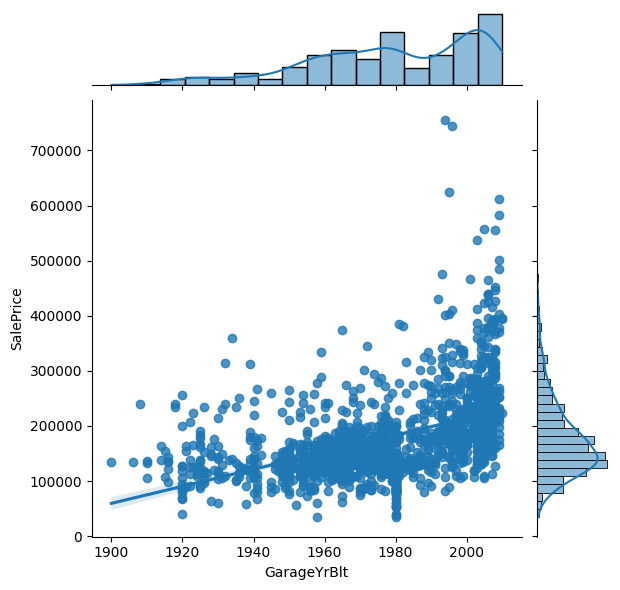

In [ ]:
sns.jointplot(x="GarageYrBlt", y="SalePrice", data=df, kind="reg");

1


[array([1.])]

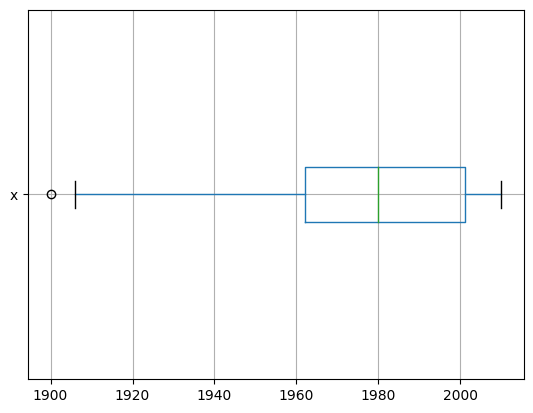

In [ ]:
_, bp = pd.DataFrame.boxplot((df['GarageYrBlt']), return_type='both',vert=False)

outliers = [flier.get_ydata() for flier in bp["fliers"]]
print(len(outliers[0]))
outliers[0].min()
outliers

Fitur `GarageYrBlte` memiliki korelasi positif terhadap SalePrice. Secara hipotesis, artinya jika semakin tinggi tahun garage atau semakin baru garage pada properti terkait maka akan berdampak pada kenaikan harga dari properti tersebut. Selain itu hanya terdapat 1 (0.068%) outlier pada `GarageYrBlt`. Yang mana berarti persebaran data masih masuk akal.

### MasVnrArea Feature

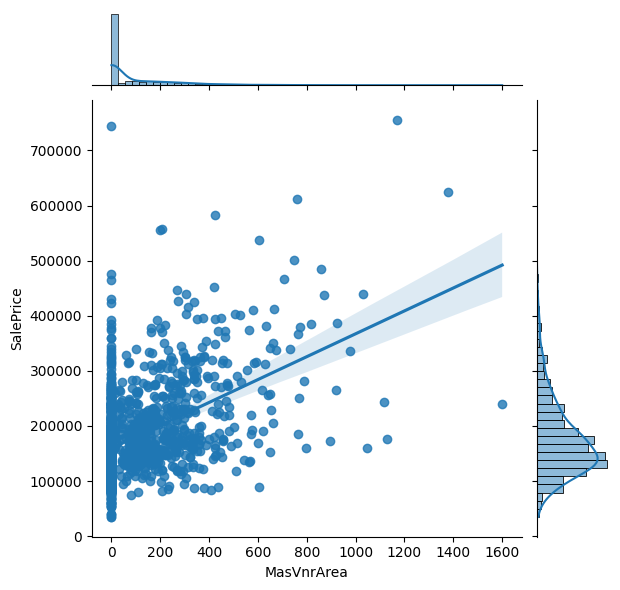

In [ ]:
sns.jointplot(x="MasVnrArea", y="SalePrice", data=df, kind="reg");

98


[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]

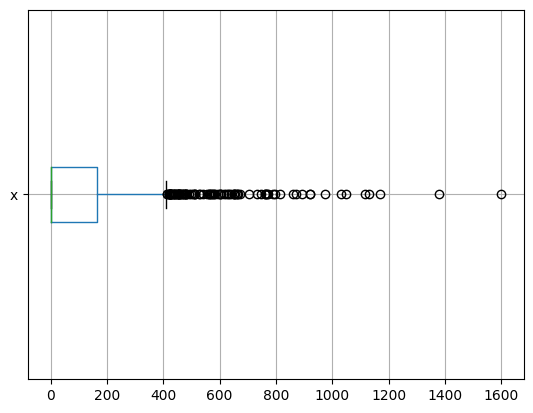

In [ ]:
_, bp = pd.DataFrame.boxplot((df['MasVnrArea']), return_type='both',vert=False)

outliers = [flier.get_ydata() for flier in bp["fliers"]]
print(len(outliers[0]))
outliers[0].min()
outliers

Fitur `MasVnrArea` memiliki korelasi positif terhadap SalePrice. Secara hipotesis, artinya jika semakin besar luas veener pada properti terkait maka akan berdampak pada kenaikan harga dari properti tersebut. Selain itu terdapat 98 (6.71%) outlier pada `MasVnrArea`, artinya ada yang memiliki luas veener yang tidak masuk akal (terlalu luas atau terlalu sempit)

## **MODELING DAN EVALUASI**

Melakukan encoding pada data kategorik

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df['MSZoning'] = labelencoder.fit_transform(df['MSZoning'])
df['Street'] = labelencoder.fit_transform(df['Street'])
df['Alley'] = labelencoder.fit_transform(df['Alley'])
df['LotShape'] = labelencoder.fit_transform(df['LotShape'])
df['LandContour'] = labelencoder.fit_transform(df['LandContour'])
df['Utilities'] = labelencoder.fit_transform(df['Utilities'])
df['LotConfig'] = labelencoder.fit_transform(df['LotConfig'])
df['LandSlope'] = labelencoder.fit_transform(df['LandSlope'])
df['Neighborhood'] = labelencoder.fit_transform(df['Neighborhood'])
df['Condition1'] = labelencoder.fit_transform(df['Condition1'])
df['Condition2'] = labelencoder.fit_transform(df['Condition2'])
df['BldgType'] = labelencoder.fit_transform(df['BldgType'])
df['HouseStyle'] = labelencoder.fit_transform(df['HouseStyle'])
df['RoofStyle'] = labelencoder.fit_transform(df['RoofStyle'])
df['RoofMatl'] = labelencoder.fit_transform(df['RoofMatl'])
df['Exterior1st'] = labelencoder.fit_transform(df['Exterior1st'])
df['Exterior2nd'] = labelencoder.fit_transform(df['Exterior2nd'])
df['MasVnrType'] = labelencoder.fit_transform(df['MasVnrType'])
df['ExterQual'] = labelencoder.fit_transform(df['ExterQual'])
df['ExterCond'] = labelencoder.fit_transform(df['ExterCond'])
df['Foundation'] = labelencoder.fit_transform(df['Foundation'])
df['BsmtQual'] = labelencoder.fit_transform(df['BsmtQual'])
df['BsmtCond'] = labelencoder.fit_transform(df['BsmtCond'])
df['BsmtExposure'] = labelencoder.fit_transform(df['BsmtExposure'])
df['BsmtFinType1'] = labelencoder.fit_transform(df['BsmtFinType1'])
df['BsmtFinType2'] = labelencoder.fit_transform(df['BsmtFinType2'])
df['Heating'] = labelencoder.fit_transform(df['Heating'])
df['HeatingQC'] = labelencoder.fit_transform(df['HeatingQC'])
df['CentralAir'] = labelencoder.fit_transform(df['CentralAir'])
df['Electrical'] = labelencoder.fit_transform(df['Electrical'])
df['KitchenQual'] = labelencoder.fit_transform(df['KitchenQual'])
df['Functional'] = labelencoder.fit_transform(df['Functional'])
df['FireplaceQu'] = labelencoder.fit_transform(df['FireplaceQu'])
df['GarageType'] = labelencoder.fit_transform(df['GarageType'])
df['GarageFinish'] = labelencoder.fit_transform(df['GarageFinish'])
df['GarageQual'] = labelencoder.fit_transform(df['GarageQual'])
df['GarageCond'] = labelencoder.fit_transform(df['GarageCond'])
df['PavedDrive'] = labelencoder.fit_transform(df['PavedDrive'])
df['PoolQC'] = labelencoder.fit_transform(df['PoolQC'])
df['Fence'] = labelencoder.fit_transform(df['Fence'])
df['MiscFeature'] = labelencoder.fit_transform(df['MiscFeature'])
df['SaleType'] = labelencoder.fit_transform(df['SaleType'])
df['SaleCondition'] = labelencoder.fit_transform(df['SaleCondition'])

df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,1,3,3,0,...,0,3,4,1,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,1,3,3,0,...,0,3,4,1,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,1,0,3,0,...,0,3,4,1,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,1,0,3,0,...,0,3,4,1,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,1,0,3,0,...,0,3,4,1,0,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,1,3,3,0,...,0,3,4,1,0,8,2007,8,4,175000
1456,1457,20,3,85.0,13175,1,1,3,3,0,...,0,3,2,1,0,2,2010,8,4,210000
1457,1458,70,3,66.0,9042,1,1,3,3,0,...,0,3,0,3,2500,5,2010,8,4,266500
1458,1459,20,3,68.0,9717,1,1,3,3,0,...,0,3,4,1,0,4,2010,8,4,142125


In [ ]:
# separating the independent and dependent variables

y = df['SalePrice']
X = df.drop(labels = ['SalePrice'], axis = 1)
print("Shape of X is {} and that of y is {}".format(X.shape, y.shape))

Shape of X is (1460, 80) and that of y is (1460,)


In [ ]:
# Splitting the dataset



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

print('Shape of training set ', X_train.shape)
print('Shape of test set ', X_test.shape)

Shape of training set  (1168, 80)
Shape of test set  (292, 80)


In [ ]:
def rmse(targets,predictions):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val

In [ ]:
regressors = [LinearRegression(),
              Lasso(),
              Ridge(),
              ElasticNet(),
              RandomForestRegressor(random_state=1),
              xgb.XGBRegressor(random_state=42)]

dc = pd.DataFrame(columns = ['Method', 'MAE', 'RMSE', 'R2 Score'])
dc

,Method,MAE,RMSE,R2 Score


In [ ]:
regressors

[LinearRegression(),
 Lasso(),
 Ridge(),
 ElasticNet(),
 RandomForestRegressor(random_state=1),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)]

In [ ]:
for regressor in regressors:
    print(regressor)

LinearRegression()
Lasso()
Ridge()
ElasticNet()
RandomForestRegressor(random_state=1)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)


In [ ]:
for regressor in regressors:
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    method = str(type(regressor)).split('.')[-1][:-2]

    # MAE score
    mae = mean_absolute_error(y_test, y_pred)

    #RMSE Score
    rmse_value = rmse(y_test, y_pred)

    #R2 Score
    r2 = r2_score(y_test, y_pred)

    dc = dc.append({'Method': method,
                    'MAE': mae,
                    'RMSE': rmse_value,
                    'R2 Score': r2},
                     ignore_index=True)

In [ ]:
dc

,Method,MAE,RMSE,R2 Score
0,LinearRegression,19973.053152,36283.510967,0.815409
1,Lasso,19974.864836,36302.421014,0.815216
2,Ridge,19975.751344,36320.511111,0.815032
3,ElasticNet,19222.162567,35748.130208,0.820816
4,RandomForestRegressor,16506.234247,27358.551344,0.895051
5,XGBRegressor,17349.637214,34447.043735,0.833622


RandomForest adalah model terbaik karena nilai RMSEnya paling rendah yakni sebesar **27358.551344**

# Tuning Hyperparameters

In [ ]:
param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10],
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

rf = RandomForestRegressor()

grid_search_forest = GridSearchCV(rf, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [10, 50, None], 'max_features': [5, 10],
                          'n_estimators': [10, 25]}],
             scoring='neg_mean_squared_error')

In [ ]:
grid_search_forest.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=10, n_estimators=25)

In [ ]:
rf = RandomForestRegressor(n_estimators=25,max_features=5)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

method = str(type(regressor)).split('.')[-1][:-2]

# MAE score
mae = mean_absolute_error(y_test, y_pred)
print('MAE : ',mae)

#RMSE Score
rmse_value = rmse(y_test, y_pred)
print('RMSE : ',rmse_value)

#R2 Score
r2 = r2_score(y_test, y_pred)
print('R2 Score : ',r2)

MAE :  17671.740136986304
RMSE :  33307.48706006783
R2 Score :  0.8444479105220903


# Feature importance

<Axes: xlabel='importance', ylabel='index'>

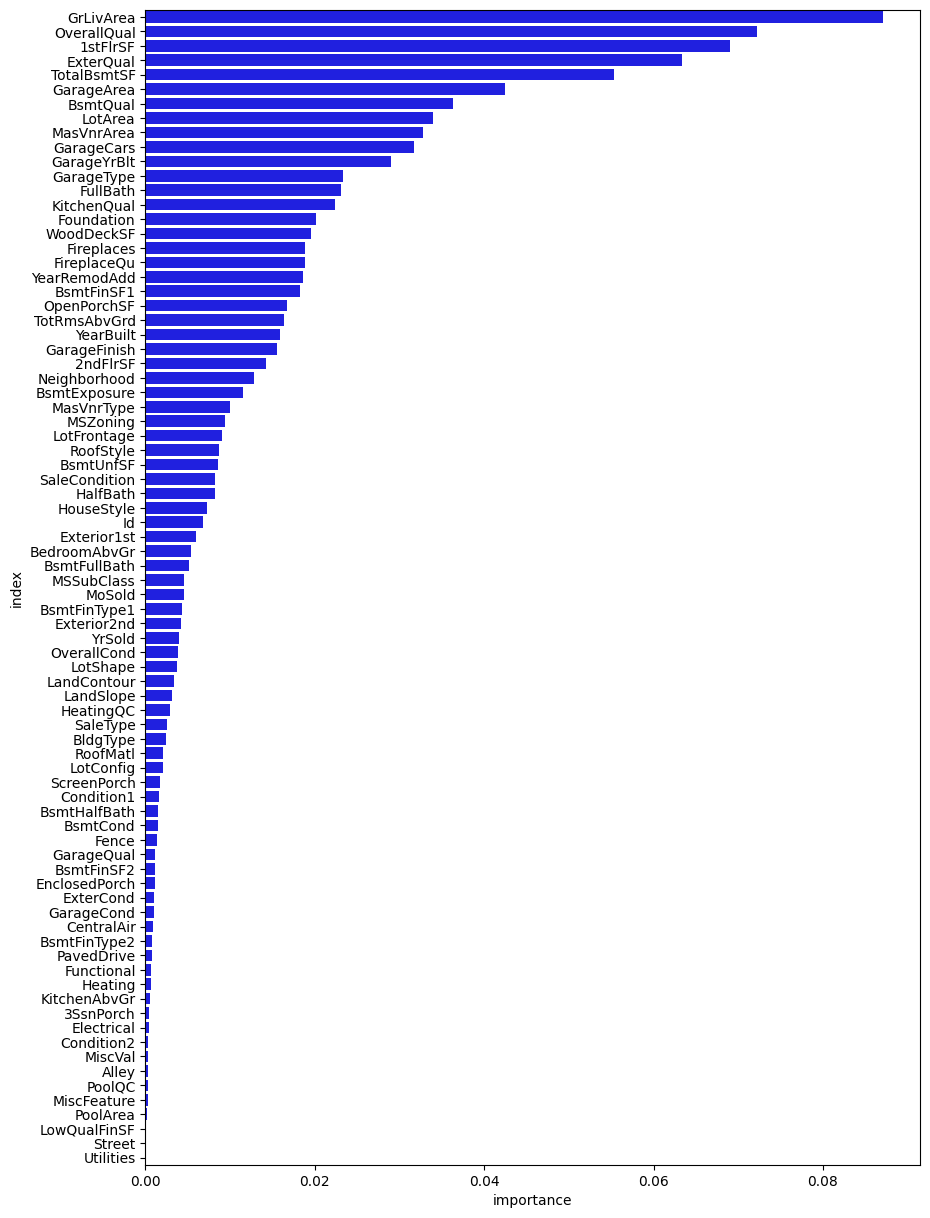

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

fig, ax = plt.subplots(1,1, figsize=(10,15))
sns.barplot(x='importance', y='index', color='Blue',data=feature_importances.reset_index())

## **INSIGHT**




*   Terdapat outlier yang cukup banyak pada data numerik. Tepatnya untuk atribut LotFrontage dan MasVnrArea
*   GrLivArea memiliki korelasi tertinggi terhadap Harga penjualan
*   RandomForestRegressor adalah model regresi terbaik untuk Data House Price karena memiliki nilai RMSE terendah dibandingkan metode lain yang sudah dilakukan dalam analisis ini
*   1stFlrSF memiliki korelasi postif terhadap Harga penjualan. Secara umum, semakin banyak luas lantai pertama maka semakin meningkat harganya.
*   dll




**.**

**.**

**.**
